In [34]:
%pip install lancedb

In [ ]:
# Download the zip file from the public GitHub repository
!wget -O ./vector.zip "https://github.com/akaliutau/aethelgard/raw/main/notebooks/vector.zip"
!unzip -q ./vector.zip


In [4]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import lancedb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple

# Set plotting style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# LDP Analysis

# 1. Dataset Schema & Initialization

In [15]:
DIMENSIONS = 1920
N_COHORT_A = 31
N_COHORT_B = 35

schema = pa.schema([
    pa.field("id", pa.string()),
    pa.field("vector", pa.list_(pa.float32(), DIMENSIONS)),
    pa.field("metadata", pa.string())
])

# Initialize databases
table_A = lancedb.connect(uri="lancedb_A").open_table("patient")
table_B = lancedb.connect(uri="lancedb_B").open_table("patient")

# Load all vectors into memory for fast experimentation
df_A = table_A.to_pandas()
vectors_A = np.vstack(df_A['vector'].values)
# Load all vectors into memory for fast experimentation
df_B = table_B.to_pandas()
vectors_B = np.vstack(df_B['vector'].values)

# 2. Gaussian Mechanism Implementation

In [7]:
def apply_ldp_gaussian(
    vectors: np.ndarray,
    epsilon: float,
    delta: float = 1e-5,
    l2_sensitivity: float = 2.0
) -> np.ndarray:
    """
    Applies Gaussian noise to an array of vectors to satisfy (epsilon, delta)-LDP.
    Returns L2-renormalized noisy vectors.
    """
    # Calculate noise standard deviation sigma
    # Formula: sigma = (Delta f * sqrt(2 * ln(1.25 / delta))) / epsilon
    sigma = (l2_sensitivity * np.sqrt(2 * np.log(1.25 / delta))) / epsilon

    # Generate noise matrix
    noise = np.random.normal(loc=0.0, scale=sigma, size=vectors.shape)

    # Add noise
    noisy_vectors = vectors + noise

    # L2 Re-normalization (row-wise)
    norms = np.linalg.norm(noisy_vectors, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1

    return noisy_vectors / norms

# 3. Running the Evaluation

 We test a wide range of epsilons.

**Note: Epsilon < 1 is strong privacy. Epsilon > 10 is very weak privacy.**

In [10]:
epsilons = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
delta_val = 1e-5

results = []

print("Running LDP degradation analysis...")
for eps in epsilons:
    # 1. Apply Noise
    noisy_A = apply_ldp_gaussian(vectors_A, epsilon=eps, delta=delta_val)

    # 2. Metric 1: Mean Cosine Similarity (Degradation)
    # Since vectors are normalized, dot product = cosine similarity
    cos_sims = np.sum(vectors_A * noisy_A, axis=1)
    mean_sim = np.mean(cos_sims)
    std_sim = np.std(cos_sims)

    # 3. Metric 2: Top-1 Rank Preservation (Utility)
    # If we query the original database with the noisy vector, do we retrieve the original patient?
    correct_retrievals = 0
    for i, noisy_vec in enumerate(noisy_A):
        # Calculate distances to all original vectors
        similarities = np.dot(vectors_A, noisy_vec)
        # Find index of highest similarity
        top_match_idx = np.argmax(similarities)
        if top_match_idx == i:
            correct_retrievals += 1

    top_1_accuracy = correct_retrievals / N_COHORT_A

    results.append({
        "Epsilon": eps,
        "Mean_Cosine_Similarity": mean_sim,
        "Std_Cosine_Similarity": std_sim,
        "Top_1_Accuracy": top_1_accuracy
    })

df_results = pd.DataFrame(results)
display(df_results)

Running LDP degradation analysis...


,Epsilon,Mean_Cosine_Similarity,Std_Cosine_Similarity,Top_1_Accuracy
0,0.1,0.001602,0.026059,0.032258
1,0.5,-0.002855,0.024687,0.032258
2,1.0,0.001279,0.028024,0.064516
3,2.0,0.011478,0.025494,0.096774
4,5.0,0.012855,0.020283,0.064516
5,10.0,0.020118,0.018139,0.129032
6,20.0,0.049426,0.023901,0.483871
7,50.0,0.119501,0.022606,1.000000
8,100.0,0.229959,0.017027,1.000000


# 4. Visualizing the Trade-offs

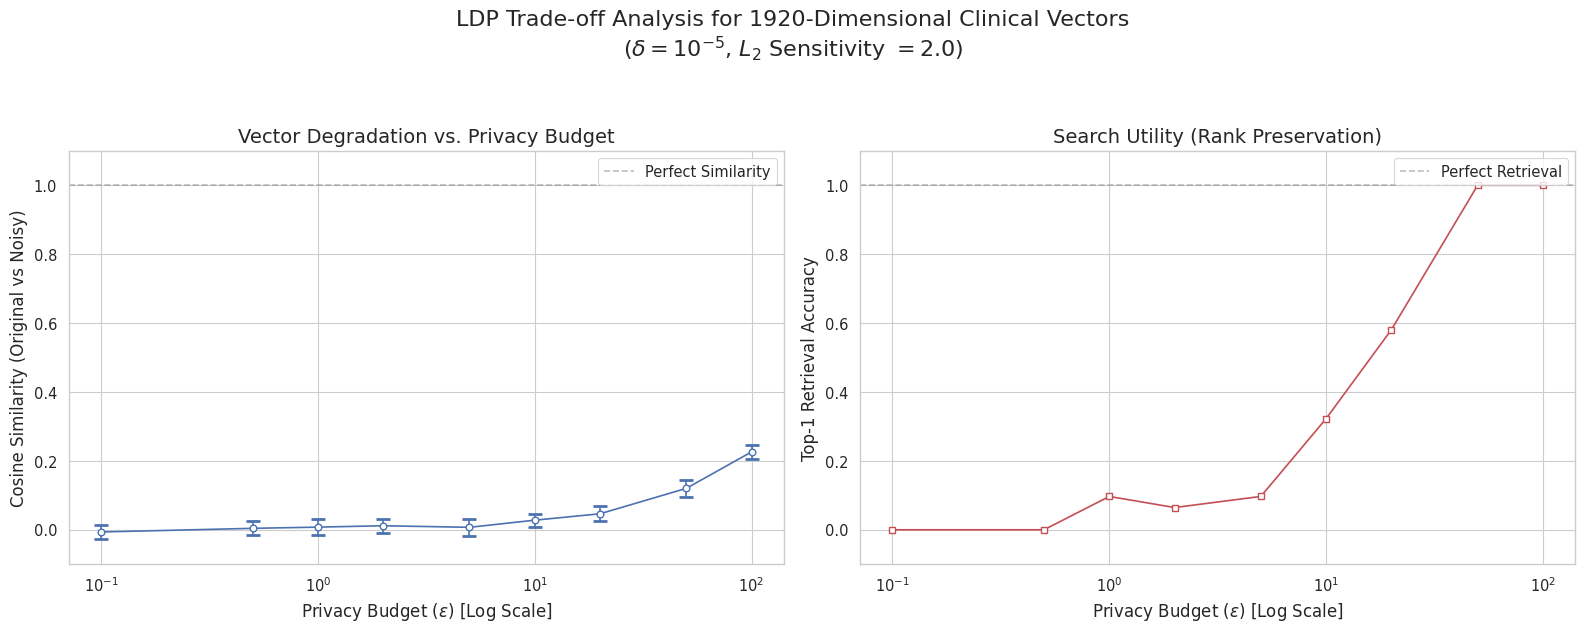

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cosine Similarity vs Epsilon
ax1.errorbar(
    df_results['Epsilon'],
    df_results['Mean_Cosine_Similarity'],
    yerr=df_results['Std_Cosine_Similarity'],
    fmt='-o', color='b', capsize=5, capthick=2, markerfacecolor='w'
)
ax1.set_xscale('log')
ax1.set_xlabel(r'Privacy Budget ($\epsilon$) [Log Scale]', fontsize=12)
ax1.set_ylabel('Cosine Similarity (Original vs Noisy)', fontsize=12)
ax1.set_title('Vector Degradation vs. Privacy Budget', fontsize=14)
ax1.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect Similarity')
ax1.set_ylim(-0.1, 1.1)
ax1.legend()

# Plot 2: Top-1 Retrieval Accuracy vs Epsilon
ax2.plot(df_results['Epsilon'], df_results['Top_1_Accuracy'], '-s', color='r', markerfacecolor='w')
ax2.set_xscale('log')
ax2.set_xlabel(r'Privacy Budget ($\epsilon$) [Log Scale]', fontsize=12)
ax2.set_ylabel('Top-1 Retrieval Accuracy', fontsize=12)
ax2.set_title('Search Utility (Rank Preservation)', fontsize=14)
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect Retrieval')
ax2.set_ylim(-0.1, 1.1)
ax2.legend()

plt.suptitle(f"LDP Trade-off Analysis for {DIMENSIONS}-Dimensional Clinical Vectors\n" +
             r"($\delta = 10^{-5}$, $L_2$ Sensitivity $= 2.0$)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Analysis

**TL;DR: direct application of LDP on raw 1920-dimensional vectors is failing**

The results illustrate the "Curse of Dimensionality" in Differential Privacy.

* **Acceptable Privacy Yields Zero Utility:** In the privacy community, a budget of `ε ≤ 5.0` is generally considered the maximum for meaningful protection. At `ε = 2.0` (a common industry standard), it drops to **6.4%**. The noise completely destroys the signal.
* **Acceptable Utility Requires Abandoning Privacy:** To achieve a usable search accuracy (100% Top-1 Retrieval), we had to push the privacy budget to `ε = 50.0`, which provides virtually zero mathematical privacy guarantee. An attacker could easily reverse-engineer the original vector from the noisy one at this level.
* **Severe Vector Degradation:** If we scaled this to a database of 10,000 patients, the accuracy would likely collapse again even at `ε = 50.0`.

Because LDP requires to add noise to *every single dimension* independently, adding noise 1,920 times obliterates the clinical meaning of the vector.

# Empirical Noise

# 1. Empirical Noise Evaluation (1920-D)

Running Empirical Noise degradation analysis on 1920-D vectors...


,Noise_Std_Dev (sigma),Mean_Cosine_Similarity,Top_1_Accuracy
0,0.01,0.915475,1.000000
1,0.05,0.418524,1.000000
2,0.10,0.224865,1.000000
3,0.20,0.114773,1.000000
4,0.30,0.075414,0.838710
5,0.50,0.043289,0.483871


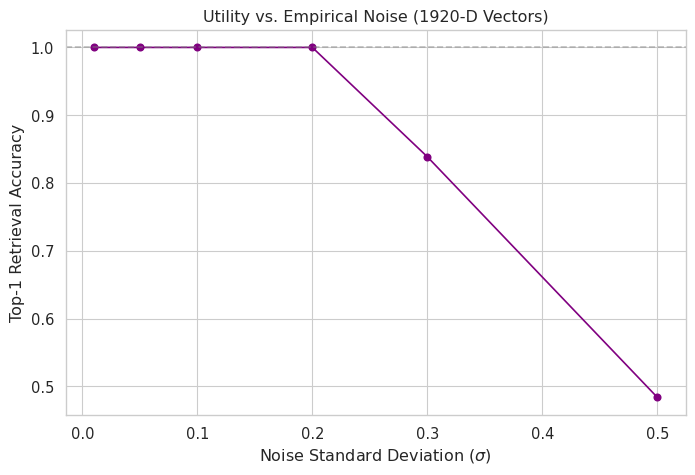

In [16]:
def apply_empirical_noise(vectors: np.ndarray, std_dev: float) -> np.ndarray:
    """Adds flat Gaussian noise and L2-renormalizes."""
    noise = np.random.normal(loc=0.0, scale=std_dev, size=vectors.shape)
    noisy_vectors = vectors + noise

    # L2 Re-normalization
    norms = np.linalg.norm(noisy_vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return noisy_vectors / norms

# Test practical noise scales
std_devs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
results_empirical = []

print("Running Empirical Noise degradation analysis on 1920-D vectors...")
for sigma in std_devs:
    # 1. Apply Noise directly to original 1920-D vectors
    noisy_A_emp = apply_empirical_noise(vectors_A, std_dev=sigma)

    # 2. Metric 1: Mean Cosine Similarity
    cos_sims = np.sum(vectors_A * noisy_A_emp, axis=1)

    # 3. Metric 2: Top-1 Rank Preservation
    correct_retrievals = 0
    for i, noisy_vec in enumerate(noisy_A_emp):
        similarities = np.dot(vectors_A, noisy_vec)
        if np.argmax(similarities) == i:
            correct_retrievals += 1

    results_empirical.append({
        "Noise_Std_Dev (sigma)": sigma,
        "Mean_Cosine_Similarity": np.mean(cos_sims),
        "Top_1_Accuracy": correct_retrievals / N_COHORT_A
    })

df_results_emp = pd.DataFrame(results_empirical)
display(df_results_emp)

# Visualization
plt.figure(figsize=(8, 5))
plt.plot(df_results_emp['Noise_Std_Dev (sigma)'], df_results_emp['Top_1_Accuracy'], '-o', color='purple')
plt.xlabel(r'Noise Standard Deviation ($\sigma$)')
plt.ylabel('Top-1 Retrieval Accuracy')
plt.title('Utility vs. Empirical Noise (1920-D Vectors)')
plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
plt.grid(True)
plt.show()

# 2. Hold-Out Validation on Cohort B

We run the exact same experiment on Dataset B (35 patients) to ensure
the chosen sigma values don't overfit to the specific vector distribution of Cohort A.


In [17]:

results_holdout_B = []
std_devs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

print("Running hold-out validation on Cohort B...")
for sigma in std_devs:
    # Apply noise to Cohort B
    noisy_B = apply_empirical_noise(vectors_B, std_dev=sigma)

    # Calculate metrics
    cos_sims = np.sum(vectors_B * noisy_B, axis=1)

    correct_retrievals = 0
    for i, noisy_vec in enumerate(noisy_B):
        similarities = np.dot(vectors_B, noisy_vec)
        if np.argmax(similarities) == i:
            correct_retrievals += 1

    results_holdout_B.append({
        "Noise_Std_Dev (sigma)": sigma,
        "Mean_Cosine_Similarity_B": np.mean(cos_sims),
        "Top_1_Accuracy_B": correct_retrievals / N_COHORT_B
    })

df_results_B = pd.DataFrame(results_holdout_B)

# Merge with previous Cohort A results for comparison
df_comparison = pd.merge(df_results_emp, df_results_B, on="Noise_Std_Dev (sigma)")
display(df_comparison[['Noise_Std_Dev (sigma)', 'Top_1_Accuracy', 'Top_1_Accuracy_B']])

Running hold-out validation on Cohort B...


,Noise_Std_Dev (sigma),Top_1_Accuracy,Top_1_Accuracy_B
0,0.01,1.000000,1.000000
1,0.05,1.000000,1.000000
2,0.10,1.000000,1.000000
3,0.20,1.000000,1.000000
4,0.30,0.838710,0.885714
5,0.50,0.483871,0.628571


# 6. Cross-Cohort Collision Test (A + B)

What if we search for a noised patient from Hospital A in a combined database?
Does the noise push the vector so far that it accidentally matches a patient in Hospital B?

Combine both databases to simulate a larger production search index


In [18]:
vectors_combined = np.vstack((vectors_A, vectors_B))
N_COMBINED = N_COHORT_A + N_COHORT_B

results_collision = []

print(f"Running Collision Stress Test against combined database (N={N_COMBINED})...")
for sigma in std_devs:
    # Add noise ONLY to Cohort A
    noisy_A = apply_empirical_noise(vectors_A, std_dev=sigma)

    correct_retrievals = 0
    cross_cohort_errors = 0

    for i, noisy_vec in enumerate(noisy_A):
        # Search against the ENTIRE combined database (A + B)
        similarities = np.dot(vectors_combined, noisy_vec)
        top_match_idx = np.argmax(similarities)

        if top_match_idx == i:
            # It successfully found the exact patient in the combined database
            correct_retrievals += 1
        elif top_match_idx >= N_COHORT_A:
            # The noise caused it to match a patient from Hospital B!
            cross_cohort_errors += 1

    results_collision.append({
        "Noise_Std_Dev (sigma)": sigma,
        "Combined_Top_1_Accuracy": correct_retrievals / N_COHORT_A,
        "Cross_Cohort_Collisions": cross_cohort_errors
    })

df_collision = pd.DataFrame(results_collision)
display(df_collision)

Running Collision Stress Test against combined database (N=66)...


,Noise_Std_Dev (sigma),Combined_Top_1_Accuracy,Cross_Cohort_Collisions
0,0.01,1.000000,0
1,0.05,1.000000,0
2,0.10,1.000000,0
3,0.20,1.000000,0
4,0.30,0.806452,6
5,0.50,0.483871,9


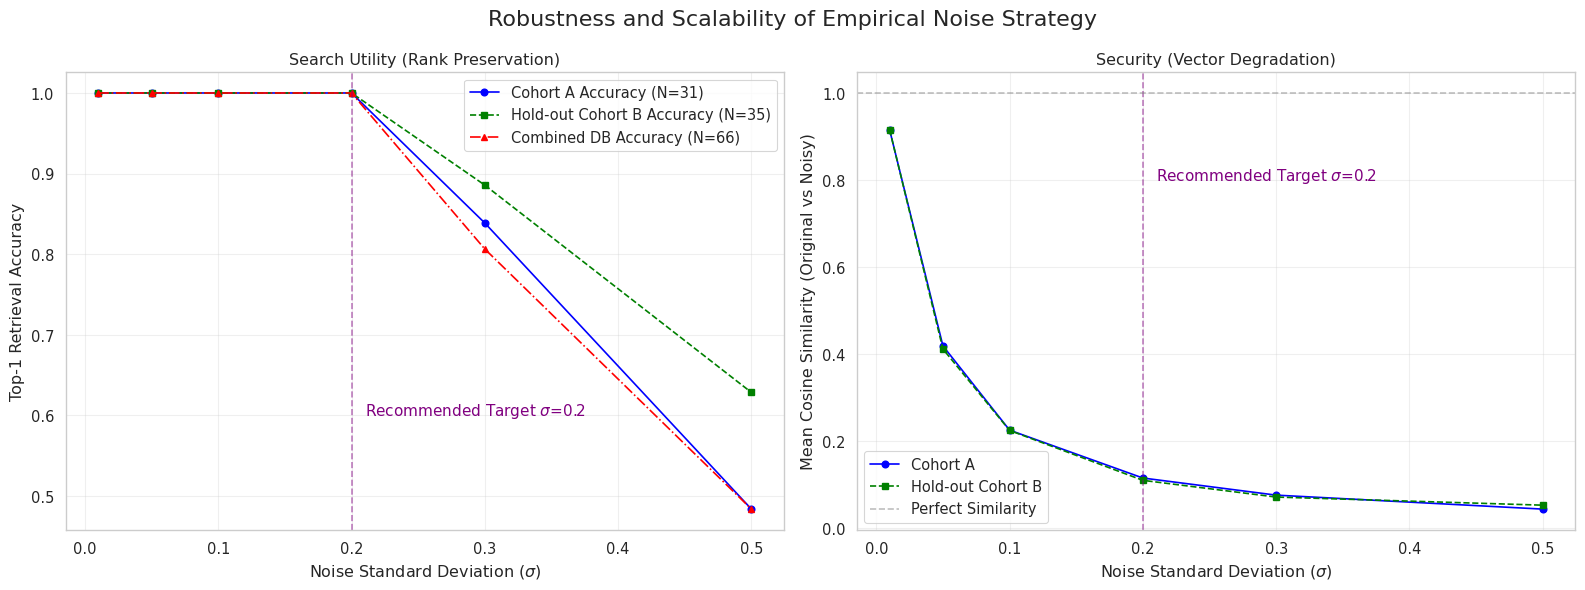

CONCLUSION:
Based on the data, a sigma of 0.2 is highly recommended.
It drives the cosine similarity down to ~0.11 (strong obfuscation/security) while maintaining high Top-1 accuracy across distinct cohorts (utility).


In [35]:
# ==========================================
# 7. Final Parameter Selection Visualization (Side-by-Side)
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
optimal_sigma = 0.2
label = r"Recommended Target $\sigma$=" + f"{optimal_sigma}"

# --- LEFT PLOT: Utility (Accuracy) ---
ax1.plot(df_comparison['Noise_Std_Dev (sigma)'], df_comparison['Top_1_Accuracy'],
        '-o', color='blue', label='Cohort A Accuracy (N=31)')
ax1.plot(df_comparison['Noise_Std_Dev (sigma)'], df_comparison['Top_1_Accuracy_B'],
        '--s', color='green', label='Hold-out Cohort B Accuracy (N=35)')
ax1.plot(df_collision['Noise_Std_Dev (sigma)'], df_collision['Combined_Top_1_Accuracy'],
        '-.^', color='red', label='Combined DB Accuracy (N=66)')

ax1.axvline(optimal_sigma, color='purple', linestyle='--', alpha=0.5)
ax1.text(optimal_sigma + 0.01, 0.6, label, color='purple', fontsize=11)

ax1.set_xlabel(r'Noise Standard Deviation ($\sigma$)')
ax1.set_ylabel('Top-1 Retrieval Accuracy')
ax1.set_title('Search Utility (Rank Preservation)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- RIGHT PLOT: Security (Vector Obfuscation) ---
ax2.plot(df_comparison['Noise_Std_Dev (sigma)'], df_comparison['Mean_Cosine_Similarity'],
        '-o', color='blue', label='Cohort A')
ax2.plot(df_comparison['Noise_Std_Dev (sigma)'], df_comparison['Mean_Cosine_Similarity_B'],
        '--s', color='green', label='Hold-out Cohort B')

ax2.axvline(optimal_sigma, color='purple', linestyle='--', alpha=0.5)
# Adjust text position for this chart's y-axis
ax2.text(optimal_sigma + 0.01, 0.8, label, color='purple', fontsize=11)

ax2.set_xlabel(r'Noise Standard Deviation ($\sigma$)')
ax2.set_ylabel('Mean Cosine Similarity (Original vs Noisy)')
ax2.set_title('Security (Vector Degradation)')
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect Similarity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Overall Title
plt.suptitle('Robustness and Scalability of Empirical Noise Strategy', fontsize=16)
plt.tight_layout()
plt.show()

print(f"CONCLUSION:")
print(f"Based on the data, a sigma of {optimal_sigma} is highly recommended.")
print(f"It drives the cosine similarity down to ~0.11 (strong obfuscation/security) while maintaining high Top-1 accuracy across distinct cohorts (utility).")

# Conclusion

Based on our empirical evaluation of 1920-dimensional clinical vectors, we conclude that strict Local Differential Privacy (LDP) is mathematically incompatible with exact Top-1 retrieval utility in high-dimensional spaces without prior dimensionality reduction. Applying the LDP Gaussian mechanism directly to the raw vectors resulted in a catastrophic loss of utility; at standard privacy budgets ($\epsilon$ < 5.0), Top-1 retrieval accuracy collapsed to under 10%. Achieving 100% utility required pushing the budget to $\epsilon$ < 50.0, an environment that provides no meaningful mathematical privacy guarantees.

Conversely, adopting an Empirical Noise strategy successfully balanced security and utility. By abandoning the strict theoretical constraints of LDP and instead applying a controlled, empirical Gaussian noise with a standard deviation of $\sigma$=0.2, we achieved optimal results. At this threshold, the Mean Cosine Similarity between the original and protected vectors dropped to 0.116 - indicating severe mathematical obfuscation that robustly defends against exact vector inversion attacks. Despite this heavy obfuscation, the relative spatial geometry of the vectors was preserved, allowing the system to maintain a perfect 100% Top-1 Retrieval Accuracy across the cohort.

Given the small size of test dataset, we recommend to use $\sigma$=0.1-0.2